<a href="https://colab.research.google.com/github/raminass/deep-NMF/blob/master/RECOMB2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Env

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/projects/deep_NMF/ongoing_research

/content/drive/MyDrive/projects/deep_NMF/ongoing_research


In [3]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import text
from ongoing_my_layers import UnsuperNet, SuperNet
import ongoing_utils as util
import pandas as pd
import sklearn.decomposition as sc
import numpy as np
import matplotlib.ticker as mticker
import joblib
import seaborn as sns

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
# plt.rcParams['figure.figsize'] = (15.0, 8.0) # set default size of plots
# plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'

# # use LaTeX fonts in the plot
# plt.rc('text', usetex=True)
# plt.rc('font', size=30)
# plt.rc('legend', fontsize=20)

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [ ]:
# # latex setting for plots
# %%capture
! sudo apt-get install texlive-latex-recommended 
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended  
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip 
! unzip type1cm.zip -d /tmp/type1cm 
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
! sudo mkdir /usr/share/texmf/tex/latex/type1cm 
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm 
! sudo texhash
!apt install cm-super ש

# Paper Plots

## Create Data

### Simulated

Run only once

In [ ]:
# import all dataset
all_mutational = {
    1: {"name": "syn.pancreas_sp.sp", "sample": 1000, "comp": 11},
    2: {"name": "syn.pancreas_sa.sa.96", "sample": 1000, "comp": 20},
    3: {"name": "syn.many.types_sp.sp", "sample": 2700, "comp": 21},
    4: {"name": "syn.many.types_sa.sa.96", "sample": 2700, "comp": 39},
    5: {"name": "syn.3.5.40.rcc.and.ovary_sp.sp", "sample": 1000, "comp": 11},
    6: {"name": "syn.3.5.40.rcc.and.ovary_sa.sa.96", "sample": 1000, "comp": 19},
    7: {"name": "syn.3.5.40.abst_sp.sp", "sample": 1000, "comp": 3},
    8: {"name": "syn.3.5.40.abst_sa.sa.96", "sample": 1000, "comp": 3},
    9: {"name": "syn.2.7a.7b.bladder.and.melanoma_sp.sp", "sample": 1000, "comp": 11},
    10: {"name": "syn.2.7a.7b.bladder.and.melanoma_sa.sa.96", "sample": 1000, "comp": 26},
    11: {"name": "syn.2.7a.7b.abst_sp.sp", "sample": 1000, "comp": 3},
    12: {"name": "syn.2.7a.7b.abst_sa.sa.96", "sample": 1000, "comp": 3},
    # # 7.1: {"name": "syn.hyper.low.sa.primary_sp.sp", "sample": 500, "comp": 2},
    # 7.2: {"name": "syn.hyper.low.sa.primary_sa.sa.96", "sample": 500, "comp": 2},
}

for k, v in all_mutational.items():
    sigs_df = pd.read_csv(
        f"data/mutation/{v['name']}/ground.truth.syn.sigs.csv", sep=","
    )
    exposures_df = pd.read_csv(
        f"data/mutation/{v['name']}/ground.truth.syn.exposures.csv", sep=","
    )
    catalog_df = pd.read_csv(
        f"data/mutation/{v['name']}/ground.truth.syn.catalog.csv", sep=","
    )
    all_mutational[k]["V"] = catalog_df.iloc[:, 2:].values  # (f,n)
    all_mutational[k]["W"] = sigs_df.iloc[:, 2:].values  # (f,k)
    all_mutational[k]["H"] = exposures_df.iloc[:, 1:].values  # (k,n)

joblib.dump(all_mutational, 'data/all_mutational.pkl.gz')

['data/all_mutational.pkl.gz']

### Synthetic

In [ ]:
synth_comp = [5, 10, 15, 20, 25]
all_synt = {}
for i, comp in enumerate(synth_comp):
    W = abs(np.random.randn(96, comp))  # (f,k) normal
    H = abs(np.random.randn(comp, 500))
    W = W / W.sum(axis=0)
    V = abs(W.dot(H) + 0.3 * np.random.randn(96, 500))  # (f,n) random noise
    all_synt[i] = {
        "name": f"synthetic_normal_{comp}",
        "sample": 500,
        "comp": comp,
        "V": V,
        "W": W,
        "H": H,
    }
joblib.dump(all_synt, 'data/all_synt.pkl.gz')

['data/all_synt.pkl.gz']

## Fig.3
Effect of regularization

In [ ]:
from sklearn.model_selection import KFold
dataset = joblib.load('data/all_mutational.pkl.gz')
n_iter = 500
layers = 10
fig_3 = pd.DataFrame()
lst = {}

kf = KFold(n_splits=5, random_state=1, shuffle=True)

for k, v in dataset.items():
    lst["super_no_reg"] = []
    lst["super_reg"] = []
    for train_index, test_index in kf.split(v["V"].T):

      data, n_components, features, samples = util.build_data(
          v["V"], v["W"], v["H"], index = train_index
      )

      #Supervised no regularization
      dnmf_model_noreg, super_dnmf_train_loss_noreg, super_dnmf_test_loss_noreg = util.train_supervised(
          data, layers, n_iter, L1=False, L2=False
      )
      #Supervised with regularization
      dnmf_model_loss_learn_L1_L2, super_dnmf_train_loss_learn_L1_L2 , super_dnmf_test_loss_learn_L1_L2= util.train_supervised(
          data, layers, n_iter, L1=True, L2=True
      )

      lst["super_no_reg"].append(super_dnmf_test_loss_noreg[-1])
      lst["super_reg"].append(super_dnmf_test_loss_learn_L1_L2[-1])

    fig_3[f"super_reg_{k}"] = lst["super_reg"]
    fig_3[f"super_no_reg{k}"] = lst["super_no_reg"]
fig_3.to_csv('data/outputs/fig_3.csv', index=False)

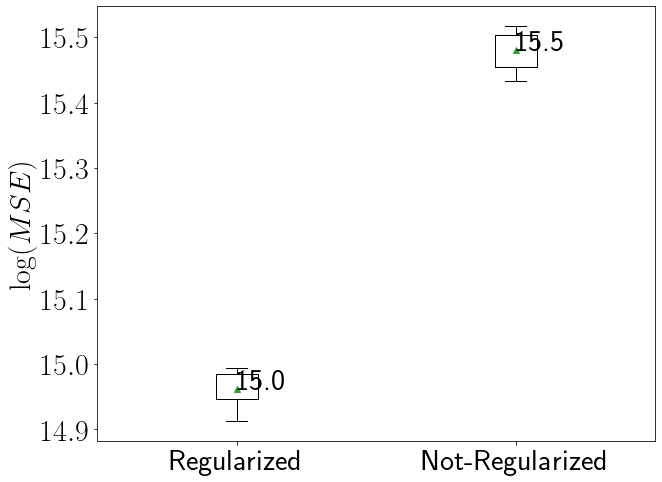

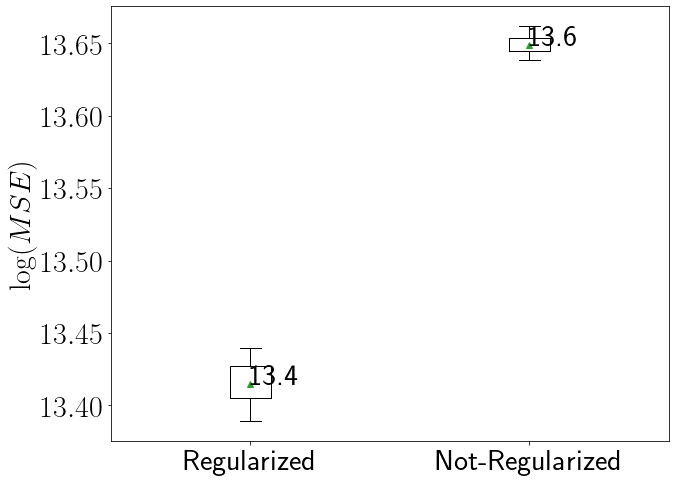

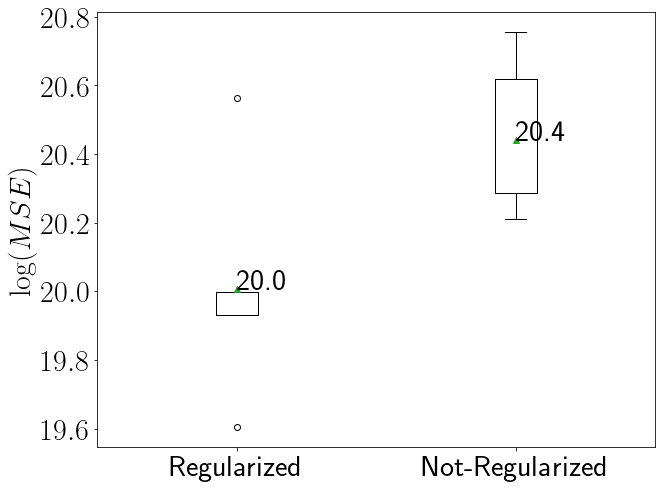

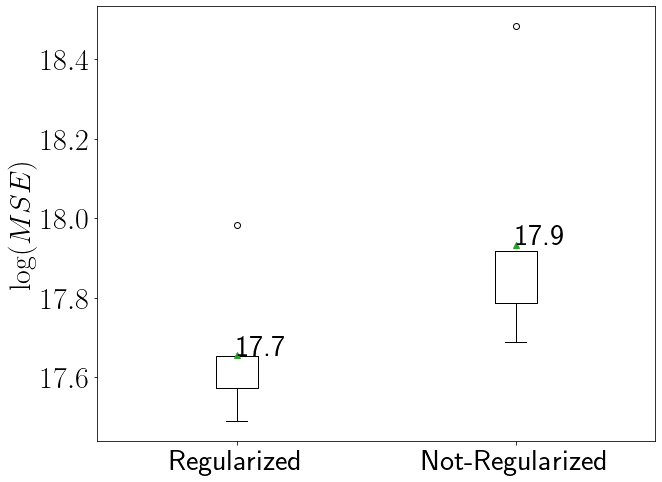

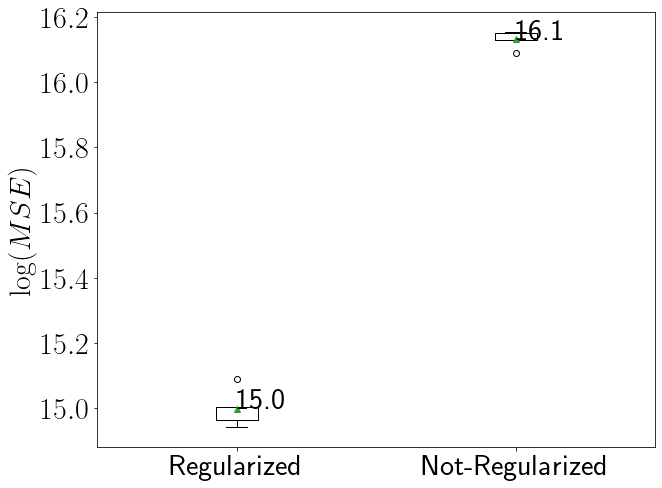

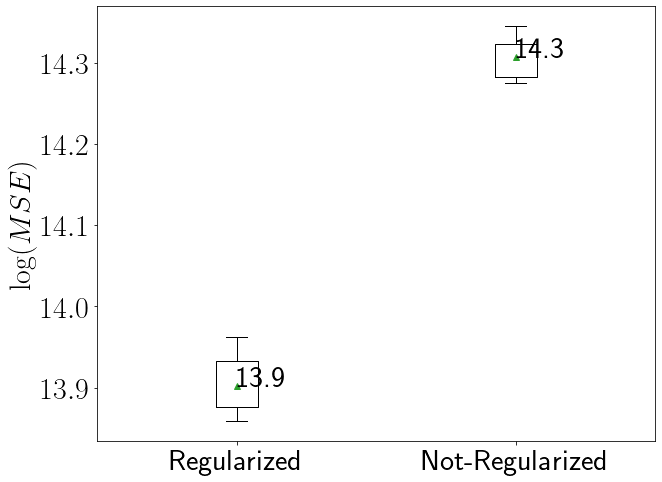

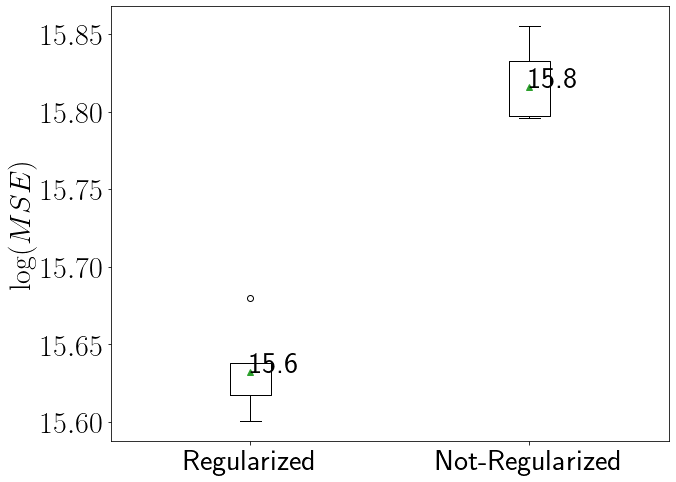

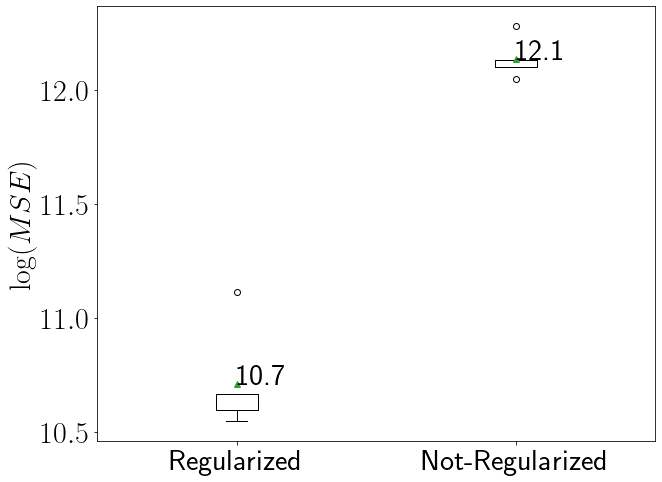

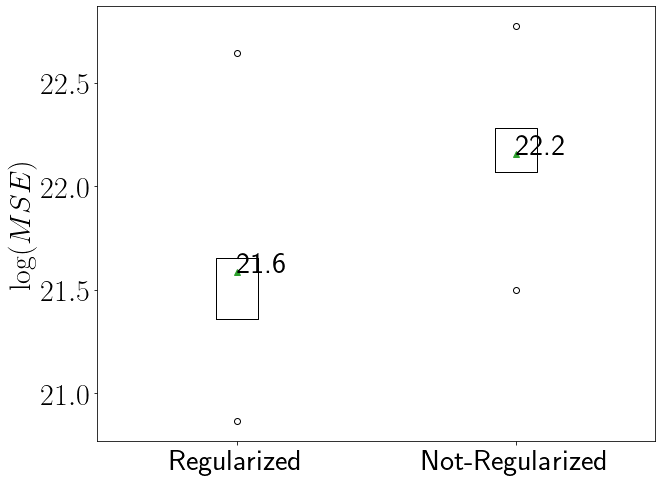

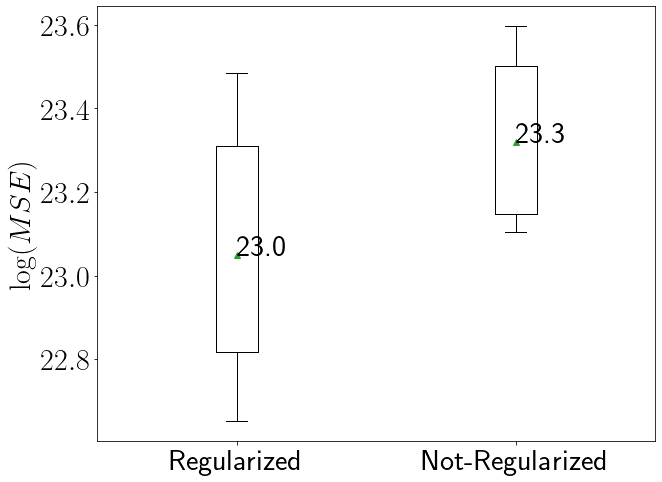

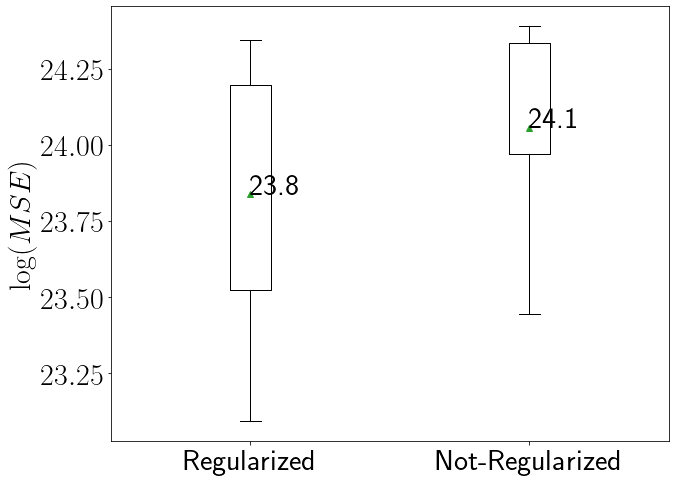

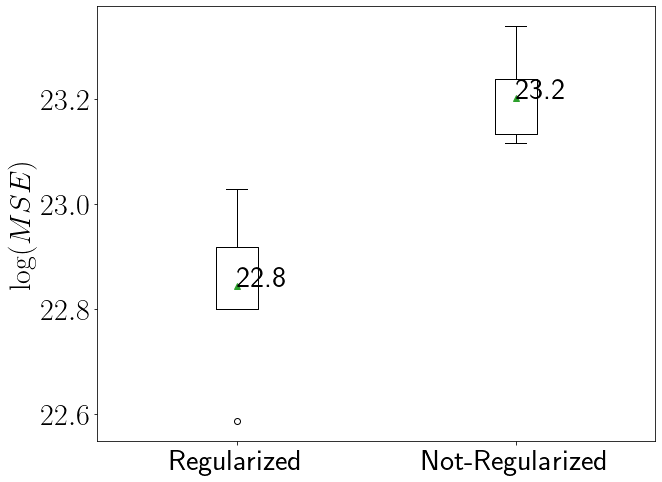

In [ ]:
fig_3 = pd.read_csv('data/outputs/fig_3.csv')
for x in range(1, 13):
  util.plot_box(
      [f"super_reg_{x}", f"super_no_reg{x}"],
      ["Regularized", "Not-Regularized"],
      f"fig3/compare_reg_{x}",
      fig_3,
      'Supervised',
      None,
      '$\log({MSE})$',
  )

In [ ]:
fig, axs = plt.subplots(3, 4)
for x in range(0, 24, 2):
  i = int(x/2)
  (axs.flat[i]).boxplot(np.log(fig_3_sim_cv.iloc[:,[x,x+1]].values))
plt.show()

## Fig.4
Effect of number of layers

In [ ]:
from sklearn.model_selection import KFold
dataset = joblib.load('data/all_mutational.pkl.gz')
n_iter = 500
fig_4 = pd.DataFrame()
layers_list = [5, 10, 15, 20]
lst = {}
avg = {}
kf = KFold(n_splits=5, random_state=1, shuffle=True)

for layers in layers_list:
      avg[f"super_{layers}"] = []
      avg[f"unsuper_{layers}"] = []

for k, v in dataset.items():

    for layers in layers_list:
      lst[f"super_{layers}"] = []
      lst[f"unsuper_{layers}"] = []
    
    for train_index, test_index in kf.split(v["V"].T):

      data, n_components, features, samples = util.build_data(
          v["V"], v["W"], v["H"], index = train_index
      )

      for layers in layers_list:
        # Supervised
        _, super_train, super_test = util.train_supervised(
        data, layers, n_iter, L1=True, L2=True )
        ##################### unsupervised performance #############################
        _, unsuper_train, unsuper_test, _ = util.train_unsupervised(
            data, layers, n_iter, n_components
        )
        
        lst[f"super_{layers}"].append(super_test[-1])
        lst[f"unsuper_{layers}"].append(unsuper_test[-1])

    for m in layers_list:
      avg[f"super_{m}"].append(round(np.average(lst[f"super_{m}"])))
      avg[f"unsuper_{m}"].append(round(np.average(lst[f"unsuper_{m}"])))

fig_4 = pd.DataFrame.from_dict(avg)
fig_4.to_csv('data/outputs/fig_4.csv', index=False)

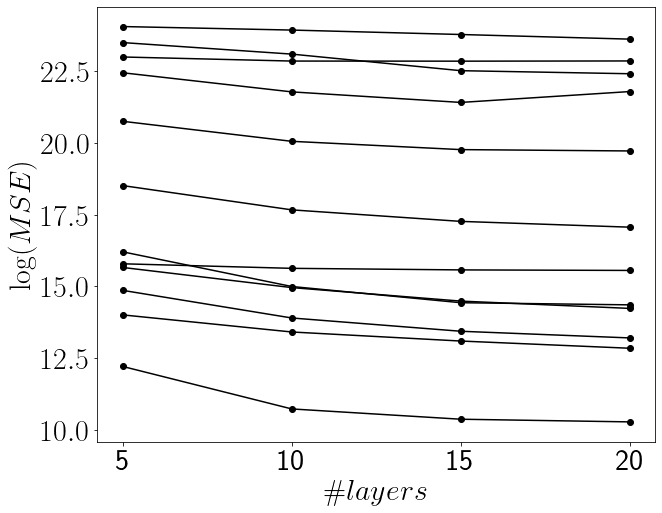

In [ ]:
fig_4 = pd.read_csv('data/outputs/fig_4.csv')
plt.rcParams['figure.figsize'] = (10.0, 8.0)
fig = plt.figure()
ax = fig.add_subplot(111)
x_axis = ['5', '10', '15', '20']
for i in range(fig_4.shape[0]):
  data1 = np.log(fig_4[['super_5', 'super_10', 'super_15', 'super_20']].loc[i])
  ax.plot(x_axis, data1,'ko-',label='line1')
ax.set_xlabel('$\# layers$')
ax.set_ylabel('$\log({MSE})$')
plt.savefig(f"plots/fig4/supervised.pdf")
plt.show()

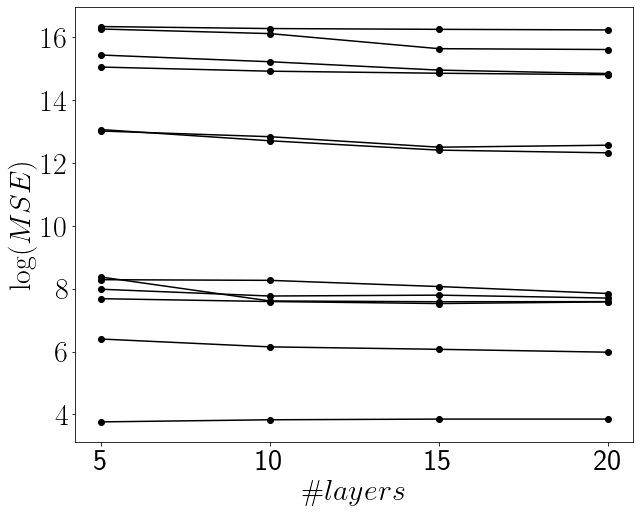

In [ ]:
fig_4 = pd.read_csv('data/outputs/fig_4.csv')
plt.rcParams['figure.figsize'] = (10.0, 8.0)
fig = plt.figure()
ax = fig.add_subplot(111)
x_axis = ['5', '10', '15', '20']
for i in range(fig_4.shape[0]):
  data1 = np.log(fig_4[['unsuper_5', 'unsuper_10', 'unsuper_15', 'unsuper_20']].loc[i])
  ax.plot(x_axis, data1,'ko-',label='line1')
ax.set_xlabel('$\# layers$')
ax.set_ylabel('$\log({MSE})$')
plt.savefig(f"plots/fig4/unsupervised.pdf")
plt.show()

## Fig.5
Supervised DNFM-MU

In [ ]:
from sklearn.model_selection import KFold
dataset = joblib.load('data/all_mutational.pkl.gz')
n_iter = 500
layers = 10
fig_5 = pd.DataFrame()
lst = {}
kf = KFold(n_splits=5, random_state=1, shuffle=True)

for k, v in dataset.items():
    lst["dnmf"] = []
    lst["dnmf_w"] = []
    for train_index, test_index in kf.split(v["V"].T):

      data, n_components, features, samples = util.build_data(
          v["V"], v["W"], v["H"], index = train_index
      )
      #Supervised DNMF
      _, _ , dnmf_error= util.train_supervised(data, layers, n_iter, L1=True, L2=True)
      lst["dnmf"].append(dnmf_error[-1])
      _, _ , dnmf_error_w= util.train_supervised_w(data, layers, n_iter, L1=True, L2=True)
      lst["dnmf_w"].append(dnmf_error_w[-1])

    fig_5[f"dnmf_{k}"] = lst["dnmf"]
    fig_5[f"dnmf_w{k}"] = lst["dnmf_w"]
fig_5.to_csv('data/outputs/fig_5.csv', index=False)

In [ ]:
fig_5 = pd.read_csv('data/outputs/fig_5.csv')
for x in range(1, 13):
  util.plot_box(
      [f"dnmf_{x}", f"dnmf_w{x}"],
      ["DNMF", "$MU_{\lambda_1=\lambda_2=0}$", "$MU_{\lambda_1=\lambda_2=1}$", "$MU_{\lambda_1=\lambda_2=2}$"],
      f"fig5/supervised_performance_{x}",
      fig_5,
      'Supervised',
      None,
      '$\log({MSE})$',
  )

## Fig.6
Unsupervised DNMF-MU mutational Data

In [ ]:
from sklearn.model_selection import KFold
dataset = joblib.load('data/all_mutational.pkl.gz')
n_iter = 500
layers = 10
fig_6 = pd.DataFrame()
lst = {}
kf = KFold(n_splits=5, random_state=1, shuffle=True)

for k, v in dataset.items():
    lst["dnmf_0"] = []
    lst["dnmf_1"] = []
    lst["dnmf_2"] = []
    lst["mu_0"] = []
    lst["mu_1"] = []
    lst["mu_2"] = []
    for train_index, test_index in kf.split(v["V"].T):

      data, n_components, features, samples = util.build_data(
          v["V"], v["W"], v["H"], index = train_index
      )

      for lam in range(3):
        L1 = lam
        L2 = lam
        ##################### unsupervised performance #############################
        _, _, dnmf_error, _ = util.train_unsupervised(
            data, layers, n_iter, n_components, l_1=L1, l_2=L2
        )
        ###### MU ################
        # train
        h_mu = data.h_0_train.mat.copy()  # k*n
        w_mu = data.w_init.mat.copy()  # f*k
        for i in range(n_iter):
            w_mu, h_mu = util.mu_update(data.v_train.mat, w_mu, h_mu, l_1=L1, l_2=L2)
        # test
        mu_test_iter = 10
        h_mu_test = data.h_0_test.mat.copy()
        for i in range(mu_test_iter):
            _, h_mu_test = util.mu_update(
                data.v_test.mat, w_mu, h_mu_test, update_W=False
            )
        mu_error = util.cost_mat(data.v_test.mat, w_mu, h_mu_test)

        lst[f"dnmf_{lam}"].append(dnmf_error[-1])
        lst[f"mu_{lam}"].append(mu_error)
      
    fig_6[f"dnmf_0_{k}"] = lst["dnmf_0"]
    fig_6[f"dnmf_1_{k}"] = lst["dnmf_1"]
    fig_6[f"dnmf_2_{k}"] = lst["dnmf_2"]
    fig_6[f"mu_0_{k}"] = lst["mu_0"]
    fig_6[f"mu_1_{k}"] = lst["mu_1"]
    fig_6[f"mu_2_{k}"] = lst["mu_2"]
fig_6.to_csv('data/outputs/fig_6.csv', index=False)

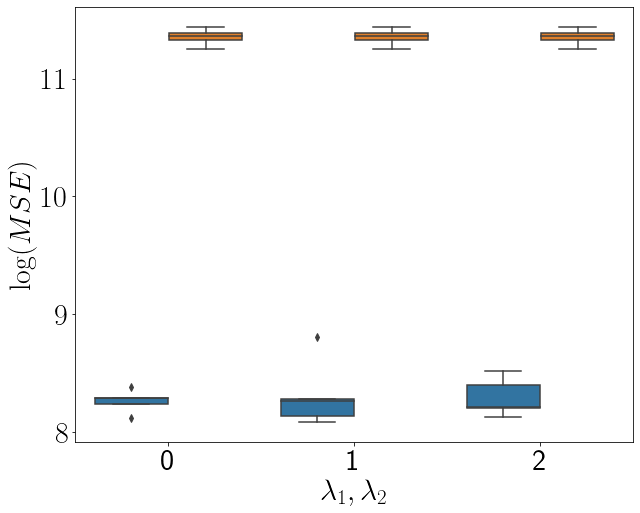

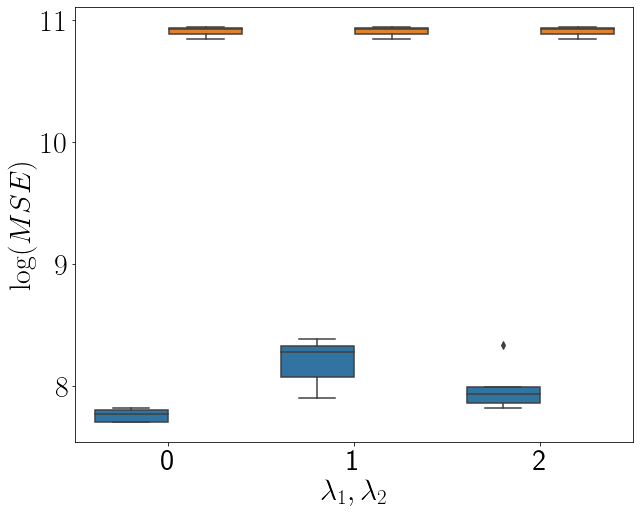

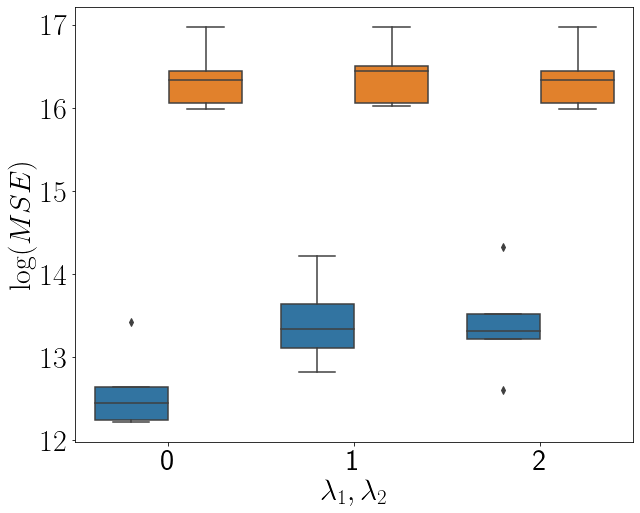

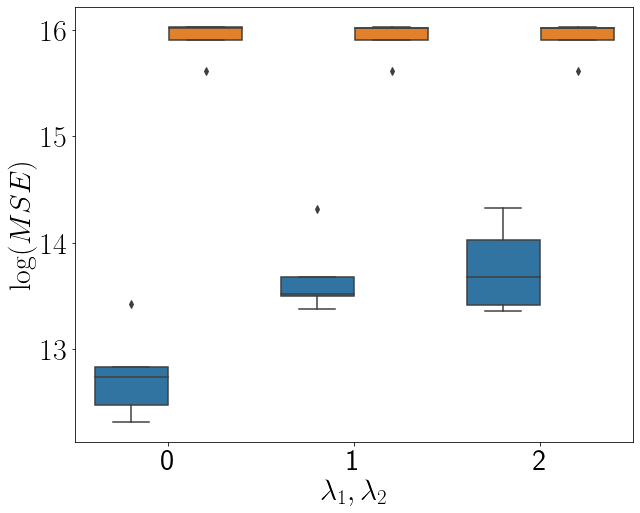

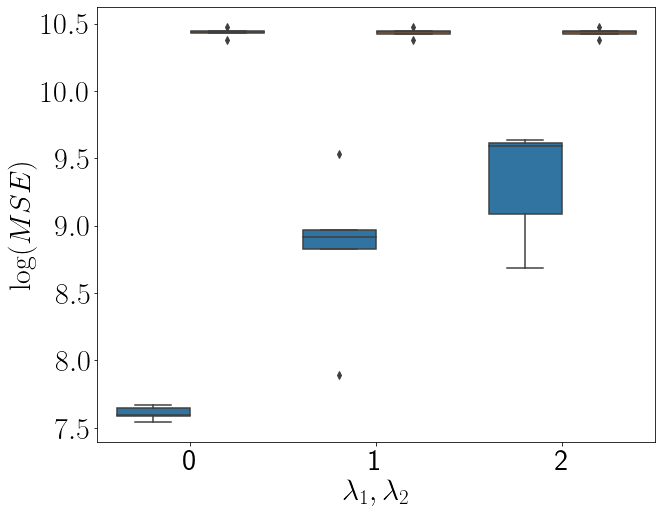

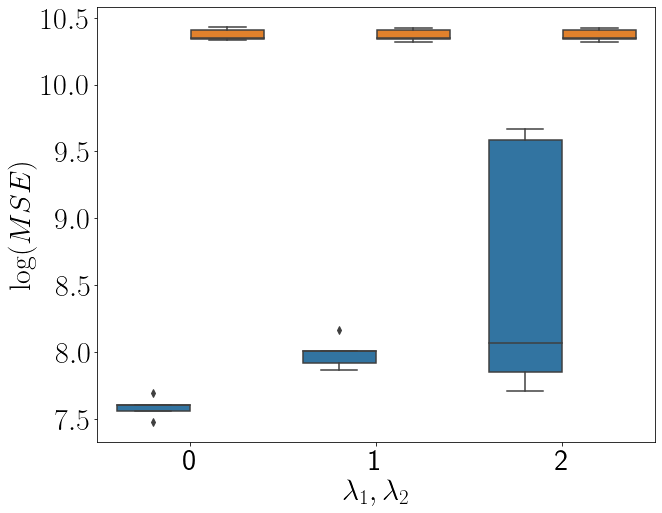

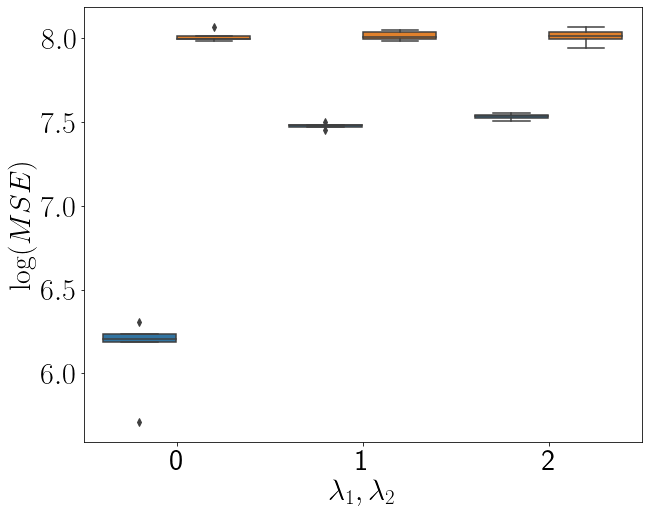

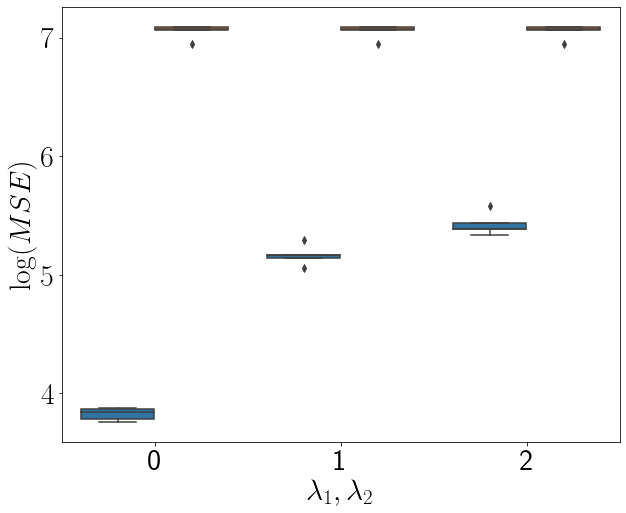

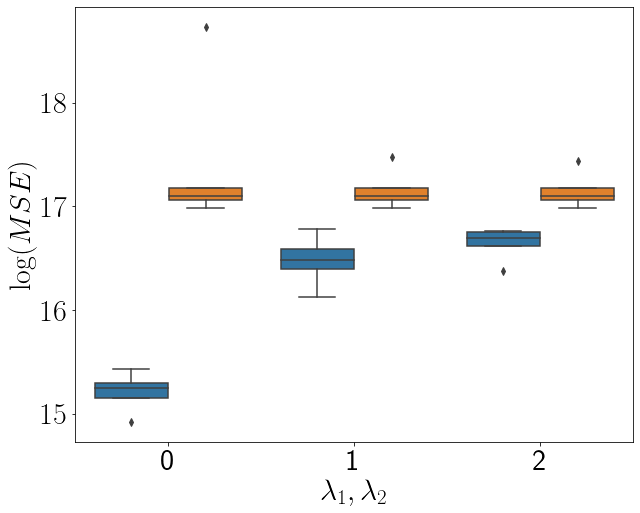

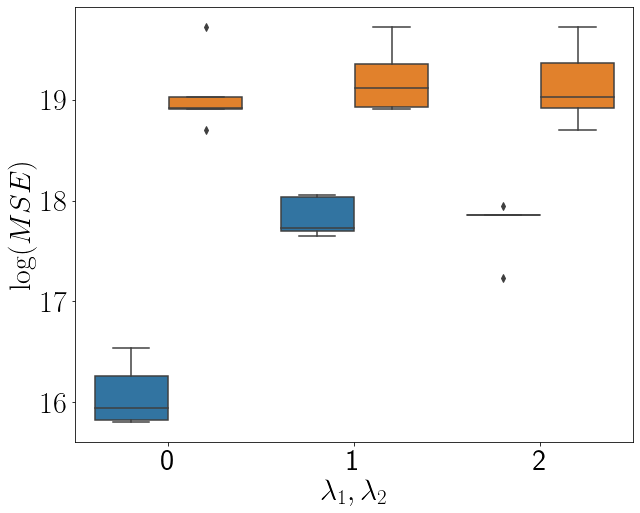

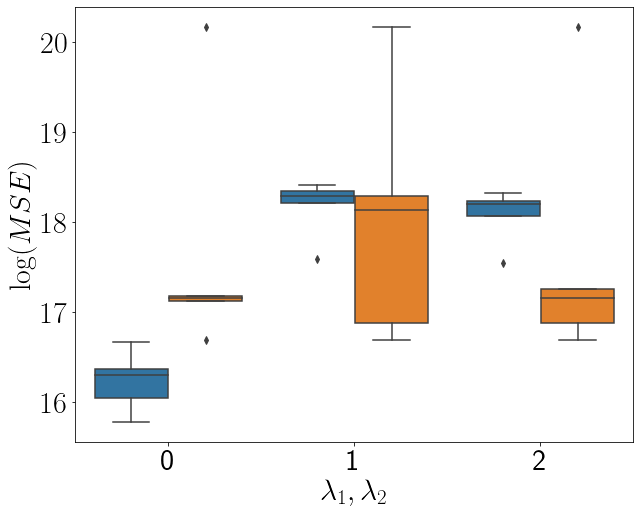

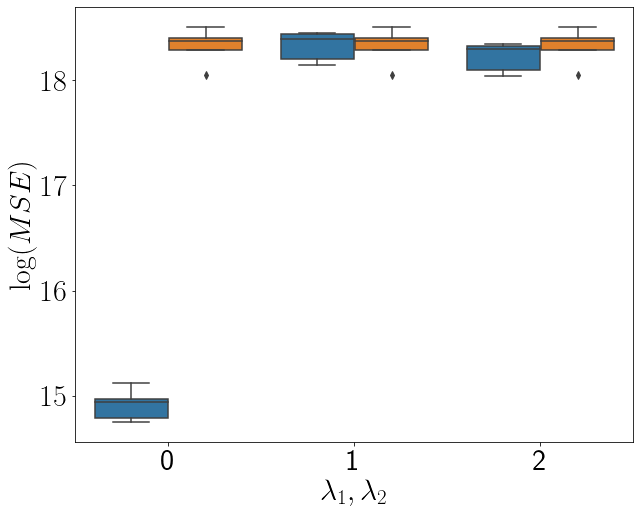

In [ ]:
fig_6 = pd.read_csv('data/outputs/fig_6.csv')
for x in range(1, 13):
  df = fig_6[[f"dnmf_0_{x}", f"mu_0_{x}", f"dnmf_1_{x}", f"mu_1_{x}", f"dnmf_2_{x}", f"mu_2_{x}"]]
  df = pd.melt(df)
  df['method'] = df.apply(lambda row: 'DNMF 'if row.variable.startswith('dnmf') else 'MU', axis = 1)
  if x>9:
    df['lambda'] = df.apply(lambda row: row.variable[-4:-3], axis = 1)
  else:
    df['lambda'] = df.apply(lambda row: row.variable[-3], axis = 1)
  df['value'] = np.log(df['value'].values)
  plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
  sns.boxplot(x='lambda',y='value',data=df,hue='method')
  plt.ylabel("$\log({MSE})$")
  plt.xlabel("${\lambda_1,\lambda_2}$")
  plt.legend([],[], frameon=False)
  plt.savefig(f"plots/fig6/unsupervised_performance_{x}.pdf")
  plt.show()

### KL

In [ ]:
from sklearn.model_selection import KFold
dataset = joblib.load('data/all_mutational.pkl.gz')
n_iter = 700
layers = 10
fig_6 = pd.DataFrame()
lst = {}
kf = KFold(n_splits=5, random_state=1, shuffle=True)

for k, v in dataset.items():
    lst["dnmf_0"] = []
    lst["dnmf_1"] = []
    lst["dnmf_2"] = []
    lst["mu_0"] = []
    lst["mu_1"] = []
    lst["mu_2"] = []
    for train_index, test_index in kf.split(v["V"].T):

      data, n_components, features, samples = util.build_data(
          v["V"], v["W"], v["H"], index = train_index
      )

      for lam in range(3):
        L1 = lam
        L2 = lam
        ##################### unsupervised performance #############################
        _, _, dnmf_error, _ = util.train_unsupervised_kl(
            data, layers, n_iter, n_components, l_1=L1, l_2=L2
        )
        ###### MU ################
        # train
        h_mu = data.h_0_train.mat.copy()  # k*n
        w_mu = data.w_init.mat.copy()  # f*k
        for i in range(n_iter):
            w_mu, h_mu = util.mu_update_kl(data.v_train.mat, w_mu, h_mu, l_1=L1, l_2=L2)
        # test
        mu_test_iter = 10
        h_mu_test = data.h_0_test.mat.copy()
        for i in range(mu_test_iter):
            _, h_mu_test = util.mu_update_kl(
                data.v_test.mat, w_mu, h_mu_test, update_W=False
            )
        mu_error = util.kl_reconstruct_error(data.v_test.mat, w_mu, h_mu_test)

        lst[f"dnmf_{lam}"].append(dnmf_error[-1])
        lst[f"mu_{lam}"].append(mu_error)
      
    fig_6[f"dnmf_0_{k}"] = lst["dnmf_0"]
    fig_6[f"dnmf_1_{k}"] = lst["dnmf_1"]
    fig_6[f"dnmf_2_{k}"] = lst["dnmf_2"]
    fig_6[f"mu_0_{k}"] = lst["mu_0"]
    fig_6[f"mu_1_{k}"] = lst["mu_1"]
    fig_6[f"mu_2_{k}"] = lst["mu_2"]
fig_6.to_csv('data/outputs/fig_simulated_KL.csv', index=False)

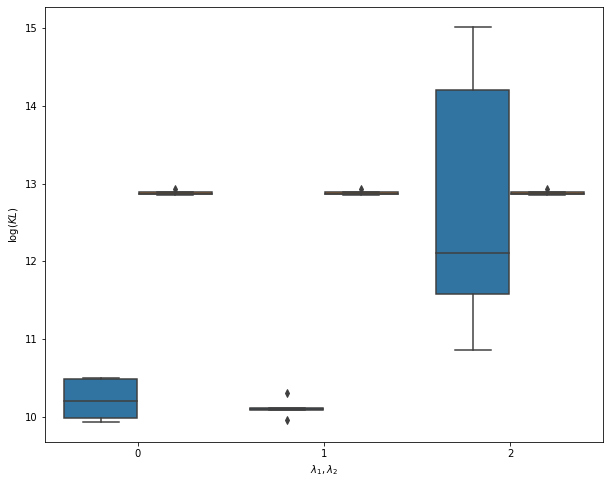

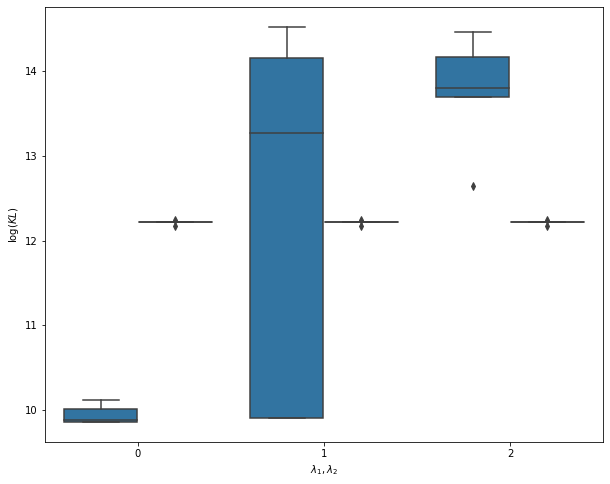

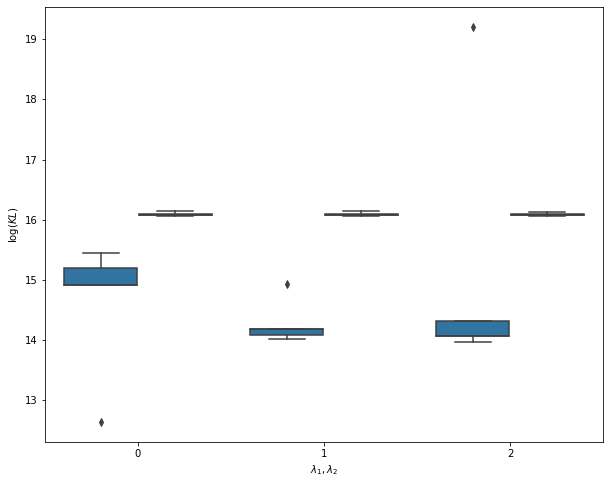

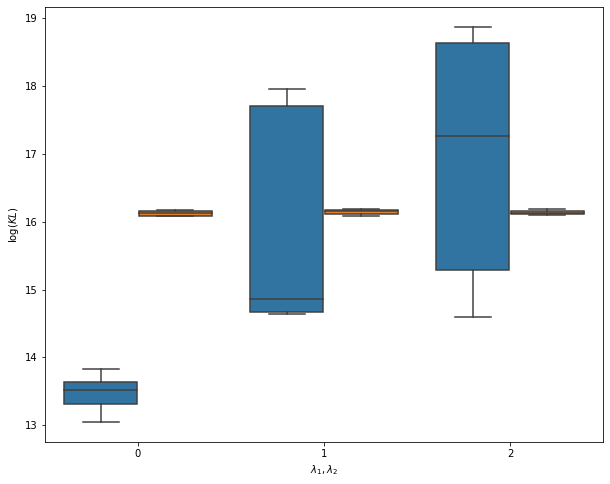

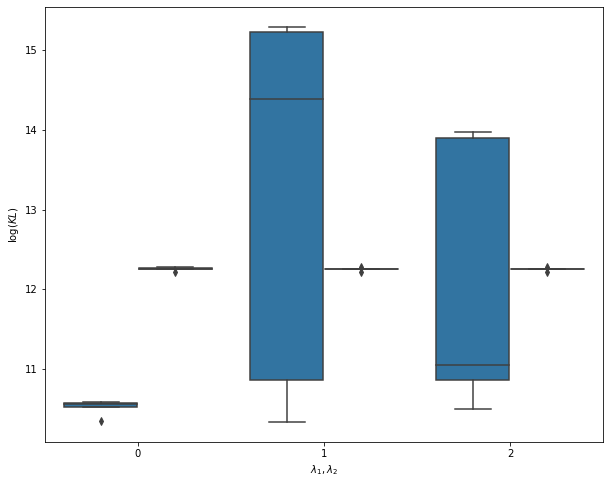

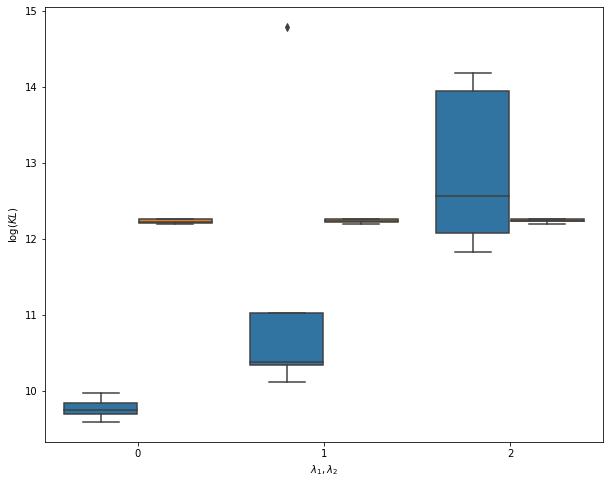

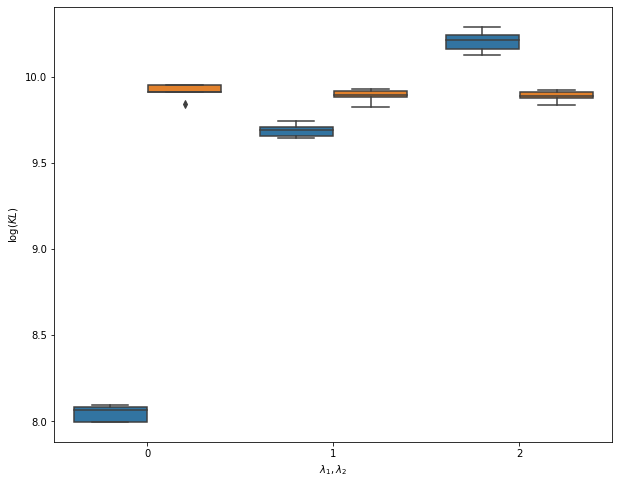

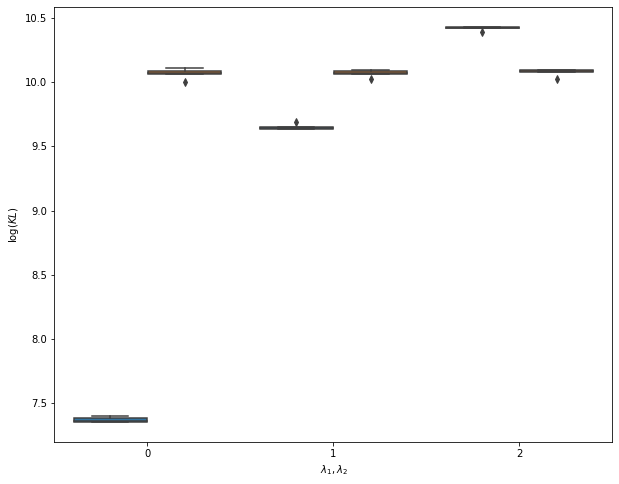

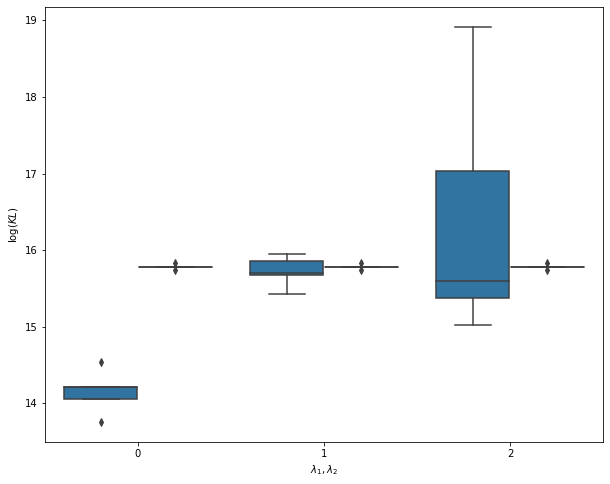

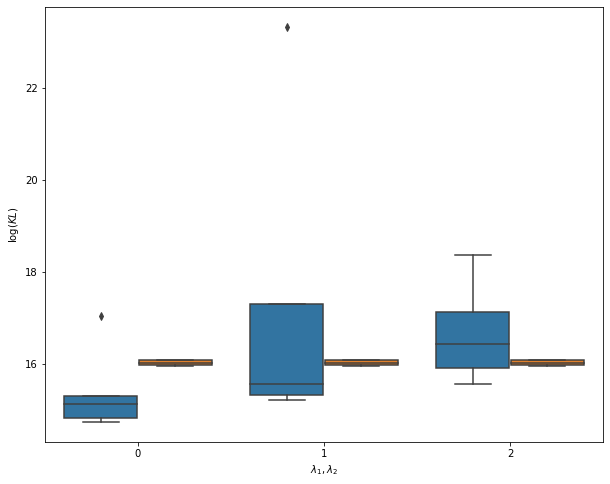

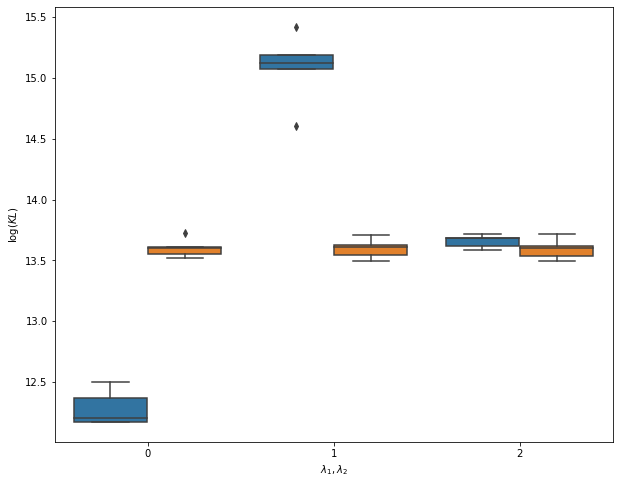

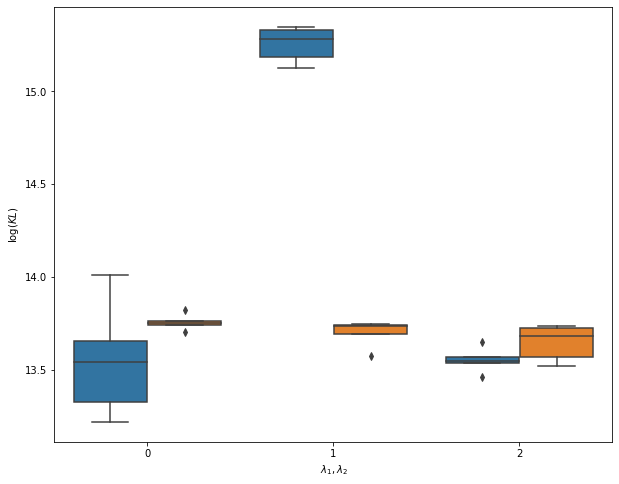

In [ ]:
fig_6 = pd.read_csv('data/outputs/fig_simulated_KL.csv')
for x in range(1, 13):
  df = fig_6[[f"dnmf_0_{x}", f"mu_0_{x}", f"dnmf_1_{x}", f"mu_1_{x}", f"dnmf_2_{x}", f"mu_2_{x}"]]
  df = pd.melt(df)
  df['method'] = df.apply(lambda row: 'DNMF 'if row.variable.startswith('dnmf') else 'MU', axis = 1)
  if x>9:
    df['lambda'] = df.apply(lambda row: row.variable[-4:-3], axis = 1)
  else:
    df['lambda'] = df.apply(lambda row: row.variable[-3], axis = 1)
  df['value'] = np.log(df['value'].values)
  plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
  sns.boxplot(x='lambda',y='value',data=df,hue='method')
  plt.ylabel("$\log({KL})$")
  plt.xlabel("${\lambda_1,\lambda_2}$")
  plt.legend([],[], frameon=False)
  plt.savefig(f"plots/fig6/unsupervised_performance_KL_{x}.pdf")
  plt.show()

## Fig.7
Unsupervised DNMF-MU BRCA


In [ ]:
from sklearn.model_selection import KFold
brca = np.load('data/BRCA_counts.npy')
n_iter = 500
layers = 10
fig_6_brca_cv = pd.DataFrame()
lst = {}
kf = KFold(n_splits=5, random_state=1, shuffle=True)

for k in range(1,2):
    lst["dnmf_0"] = []
    lst["dnmf_1"] = []
    lst["dnmf_2"] = []
    lst["mu_0"] = []
    lst["mu_1"] = []
    lst["mu_2"] = []
    V = brca.T
    for train_index, test_index in kf.split(V.T):
      W = abs(np.random.randn(V.shape[0], 12))  # (f,k) normal
      H = abs(np.random.randn(12, V.shape[1]))  # (k,n) normal
      data, n_components, features, samples = util.build_data(
          V, W, H,index = train_index
      )

      for lam in range(3):
        L1 = lam
        L2 = lam
        ##################### unsupervised performance #############################
        _, _, dnmf_error, _ = util.train_unsupervised(
            data, layers, n_iter, n_components, l_1=L1, l_2=L2
        )

        ###### MU ################
        # train
        h_mu = data.h_0_train.mat.copy()  # k*n
        w_mu = data.w_init.mat.copy()  # f*k
        for i in range(n_iter):
            w_mu, h_mu = util.mu_update(data.v_train.mat, w_mu, h_mu, l_1=L1, l_2=L2)
        # test
        mu_test_iter = 10
        h_mu_test = data.h_0_test.mat.copy()
        for i in range(mu_test_iter):
            _, h_mu_test = util.mu_update(
                data.v_test.mat, w_mu, h_mu_test, update_W=False
            )
        mu_error = util.cost_mat(data.v_test.mat, w_mu, h_mu_test, l_1=L1, l_2=L2)

        lst[f"dnmf_{lam}"].append(dnmf_error[-1])
        lst[f"mu_{lam}"].append(mu_error)
      
    fig_6_brca_cv[f"dnmf_0_{k}"] = lst["dnmf_0"]
    fig_6_brca_cv[f"dnmf_1_{k}"] = lst["dnmf_1"]
    fig_6_brca_cv[f"dnmf_2_{k}"] = lst["dnmf_2"]
    fig_6_brca_cv[f"mu_0_{k}"] = lst["mu_0"]
    fig_6_brca_cv[f"mu_1_{k}"] = lst["mu_1"]
    fig_6_brca_cv[f"mu_2_{k}"] = lst["mu_2"]
fig_6_brca_cv.to_csv('data/outputs/fig_7.csv', index=False)

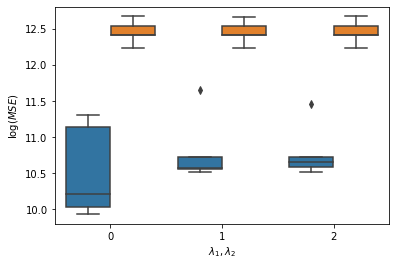

In [ ]:
fig_6_brca_cv = pd.read_csv('data/outputs/fig_7.csv')
for x in range(1, 2):
  df = fig_6_brca_cv[[f"dnmf_0_{x}", f"mu_0_{x}", f"dnmf_1_{x}", f"mu_1_{x}", f"dnmf_2_{x}", f"mu_2_{x}"]]
  df = pd.melt(df)
  df['method'] = df.apply(lambda row: 'DNMF 'if row.variable.startswith('dnmf') else 'MU', axis = 1)
  if x>9:
    df['lambda'] = df.apply(lambda row: row.variable[-4:-3], axis = 1)
  else:
    df['lambda'] = df.apply(lambda row: row.variable[-3], axis = 1)
  df['value'] = np.log(df['value'].values)
  # plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
  sns.boxplot(x='lambda',y='value',data=df,hue='method')
  plt.ylabel("$\log({MSE})$")
  plt.xlabel("${\lambda_1,\lambda_2}$")
  plt.legend([],[], frameon=False)
  plt.savefig(f"plots/fig7/unsupervised_performance_brca.pdf")
  plt.show()


### KL

In [6]:
from sklearn.model_selection import KFold
brca = np.load('data/BRCA_counts.npy')
n_iter = 500
layers = 10
fig_brca_cv_kl = pd.DataFrame()
lst = {}
kf = KFold(n_splits=5, random_state=1, shuffle=True)

for k in range(1,2):
    lst["dnmf_0"] = []
    lst["dnmf_1"] = []
    lst["dnmf_2"] = []
    lst["mu_0"] = []
    lst["mu_1"] = []
    lst["mu_2"] = []
    V = brca.T
    for train_index, test_index in kf.split(V.T):
      W = abs(np.random.randn(V.shape[0], 12))  # (f,k) normal
      H = abs(np.random.randn(12, V.shape[1]))  # (k,n) normal
      data, n_components, features, samples = util.build_data(
          V, W, H,index = train_index
      )

      for lam in range(3):
        L1 = lam
        L2 = lam
        ##################### unsupervised performance #############################
        _, _, dnmf_error, _ = util.train_unsupervised_kl(
            data, layers, n_iter, n_components, l_1=L1, l_2=L2
        )

        ###### MU ################
        # train
        h_mu = data.h_0_train.mat.copy()  # k*n
        w_mu = data.w_init.mat.copy()  # f*k
        for i in range(n_iter):
            w_mu, h_mu = util.mu_update_kl(data.v_train.mat, w_mu, h_mu, l_1=L1, l_2=L2)
        # test
        mu_test_iter = 10
        h_mu_test = data.h_0_test.mat.copy()
        for i in range(mu_test_iter):
            _, h_mu_test = util.mu_update_kl(
                data.v_test.mat, w_mu, h_mu_test, update_W=False
            )
        mu_error = util.kl_reconstruct_error(data.v_test.mat, w_mu, h_mu_test, l_1=L1, l_2=L2)

        lst[f"dnmf_{lam}"].append(dnmf_error[-1])
        lst[f"mu_{lam}"].append(mu_error)
      
    fig_brca_cv_kl[f"dnmf_0_{k}"] = lst["dnmf_0"]
    fig_brca_cv_kl[f"dnmf_1_{k}"] = lst["dnmf_1"]
    fig_brca_cv_kl[f"dnmf_2_{k}"] = lst["dnmf_2"]
    fig_brca_cv_kl[f"mu_0_{k}"] = lst["mu_0"]
    fig_brca_cv_kl[f"mu_1_{k}"] = lst["mu_1"]
    fig_brca_cv_kl[f"mu_2_{k}"] = lst["mu_2"]
fig_brca_cv_kl.to_csv('data/outputs/fig_brca_cv_kl.csv', index=False)

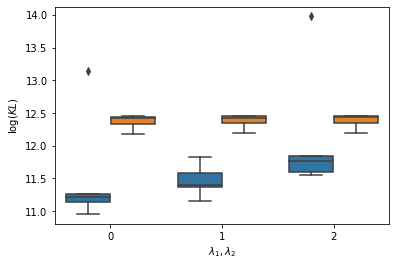

In [8]:
fig_6_brca_cv = pd.read_csv('data/outputs/fig_brca_cv_kl.csv')
for x in range(1, 2):
  df = fig_6_brca_cv[[f"dnmf_0_{x}", f"mu_0_{x}", f"dnmf_1_{x}", f"mu_1_{x}", f"dnmf_2_{x}", f"mu_2_{x}"]]
  df = pd.melt(df)
  df['method'] = df.apply(lambda row: 'DNMF 'if row.variable.startswith('dnmf') else 'MU', axis = 1)
  if x>9:
    df['lambda'] = df.apply(lambda row: row.variable[-4:-3], axis = 1)
  else:
    df['lambda'] = df.apply(lambda row: row.variable[-3], axis = 1)
  df['value'] = np.log(df['value'].values)
  # plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
  sns.boxplot(x='lambda',y='value',data=df,hue='method')
  plt.ylabel("$\log({KL})$")
  plt.xlabel("${\lambda_1,\lambda_2}$")
  plt.legend([],[], frameon=False)
  plt.savefig(f"plots/fig7/unsupervised_performance_brca_kl.pdf")
  plt.show()


### RANDOM

In [ ]:
from sklearn.model_selection import KFold
brca = np.load('data/BRCA_counts.npy')
n_iter = 500
layers = 10
fig_6_brca_random = pd.DataFrame()
lst = {}
kf = KFold(n_splits=5, random_state=1, shuffle=True)

for k in range(1,2):
    lst["dnmf_0"] = []
    lst["dnmf_1"] = []
    lst["dnmf_2"] = []
    lst["mu_0"] = []
    lst["mu_1"] = []
    lst["mu_2"] = []
    V = brca.T
    
    for train_index, test_index in kf.split(V.T):
      W = abs(np.random.randn(V.shape[0], 12))  # (f,k) normal
      H = abs(np.random.randn(12, V.shape[1]))  # (k,n) normal
      data, n_components, features, samples = util.build_data(
          V, W, H
      )

      for lam in range(3):
        L1 = lam
        L2 = lam
        ##################### unsupervised performance #############################
        _, _, dnmf_error, _ = util.train_unsupervised(
            data, layers, n_iter, n_components, l_1=L1, l_2=L2
        )
        ###### MU ################
        # train
        h_mu = H[:, train_index].copy()  # k*n
        w_mu = W.copy()  # f*k
        for i in range(n_iter):
            w_mu, h_mu = util.mu_update(V[:, train_index], w_mu, h_mu, l_1=L1, l_2=L2)
        # test
        mu_test_iter = 10
        h_mu_test = H[:, ~train_index].copy()
        for i in range(mu_test_iter):
            _, h_mu_test = util.mu_update(
                V[:, ~train_index], w_mu, h_mu_test, update_W=False
            )
        mu_error = util.cost_mat(V[:, ~train_index], w_mu, h_mu_test)

        lst[f"dnmf_{lam}"].append(dnmf_error[-1])
        lst[f"mu_{lam}"].append(mu_error)
      
    fig_6_brca_random[f"dnmf_0_{k}"] = lst["dnmf_0"]
    fig_6_brca_random[f"dnmf_1_{k}"] = lst["dnmf_1"]
    fig_6_brca_random[f"dnmf_2_{k}"] = lst["dnmf_2"]
    fig_6_brca_random[f"mu_0_{k}"] = lst["mu_0"]
    fig_6_brca_random[f"mu_1_{k}"] = lst["mu_1"]
    fig_6_brca_random[f"mu_2_{k}"] = lst["mu_2"]
fig_6_brca_random.to_csv('data/outputs/fig_6_brca_random.csv', index=False)

In [ ]:
fig_6_brca_random = pd.read_csv('data/outputs/fig_6_brca_random.csv')
for x in range(1, 2):
  df = fig_6_brca_random[[f"dnmf_0_{x}", f"mu_0_{x}", f"dnmf_1_{x}", f"mu_1_{x}", f"dnmf_2_{x}", f"mu_2_{x}"]]
  df = pd.melt(df)
  df['method'] = df.apply(lambda row: 'DNMF 'if row.variable.startswith('dnmf') else 'MU', axis = 1)
  if x>9:
    df['lambda'] = df.apply(lambda row: row.variable[-4:-3], axis = 1)
  else:
    df['lambda'] = df.apply(lambda row: row.variable[-3], axis = 1)
  df['value'] = np.log(df['value'].values)
  plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
  sns.boxplot(x='lambda',y='value',data=df,hue='method')
  plt.ylabel("$\log({MSE})$")
  plt.xlabel("${\lambda_1,\lambda_2}$")
  # plt.savefig(f"plots/fig6/unsupervised_performance_brca_random.pdf")
  plt.show()


## Fig.8

In [ ]:
from sklearn.decomposition._nmf import _initialize_nmf
n_iter = 1500
layers = 10
brca = np.load('data/BRCA_counts.npy')
V = brca.T
W = abs(np.random.randn(V.shape[0], 12))  # (f,k) normal
H = abs(np.random.randn(12, V.shape[1]))  # (k,n) normal
data, n_components, features, samples = util.build_data(
    V, W, H)

fig_7_brca = pd.DataFrame()
TRAIN_SIZE = 0.80
mask = np.random.rand(samples) < TRAIN_SIZE
W_init, H_init = _initialize_nmf(V, 12, init='random')
for lam in range(3):
  L1 = lam
  L2 = lam
  
  ##################### unsupervised performance #############################
  _, dnmf_train, dnmf_error, dnmf_w = util.train_unsupervised(data, layers, n_iter, n_components, l_1=L1,l_2=L2, lr=0.001)

  ###### MU ################
  # train
  h_mu = H_init[:, mask]  # k*n
  w_mu = W_init
  mu_training_cost = []
  mu_super_test = []
  for i in range(n_iter):
      w_mu, h_mu = util.mu_update(V[:, mask], w_mu, h_mu,l_1=L1,l_2=L2)
      mu_training_cost.append(util.cost_mat(V[:, mask], w_mu, h_mu,l_1=L1,l_2=L2))
      # test
      mu_test_iter = 10
      h_mu_test = H_init[:,~mask]
      for i in range(mu_test_iter):
          _, h_mu_test = util.mu_update(
              V[:,~mask], w_mu, h_mu_test, update_W=False
          )
      mu_super_test.append(util.cost_mat(V[:,~mask], w_mu, h_mu_test))

  fig_7_brca[f'dnmf_L{L1}'] = dnmf_error
  fig_7_brca[f'MU_L{L1}'] = mu_super_test

fig_7_brca.to_csv('data/outputs/fig_7_brca.csv', index=False)

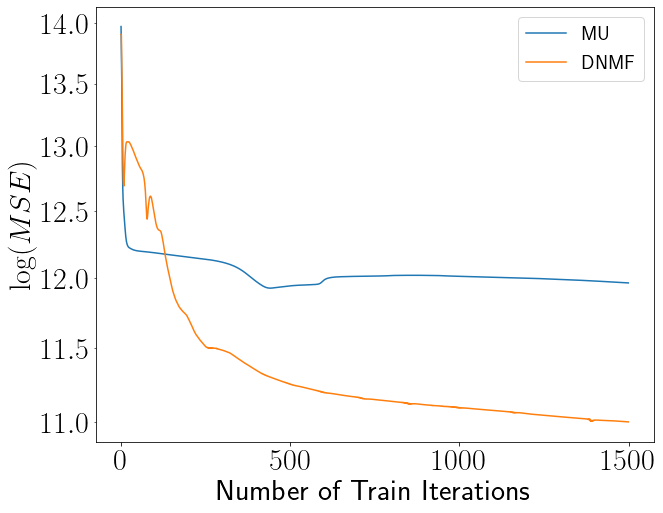

In [ ]:
  plt.rcParams['figure.figsize'] = (10, 8.0)
  epochs = range(0, mu_test_iter - 1)
  plt.semilogy(np.log(fig_7_brca['MU_L0']), label="MU")
  plt.semilogy(np.log(fig_7_brca['dnmf_L0']), label="DNMF")
  plt.xlabel("Number of Train Iterations")
  plt.ylabel("$\log(MSE)$")
  plt.legend()
  ax=plt.gca()
  ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())
  plt.savefig(f"plots/fig8/unsupervised_brca_mu_compare_train_L0.pdf")
  plt.show()

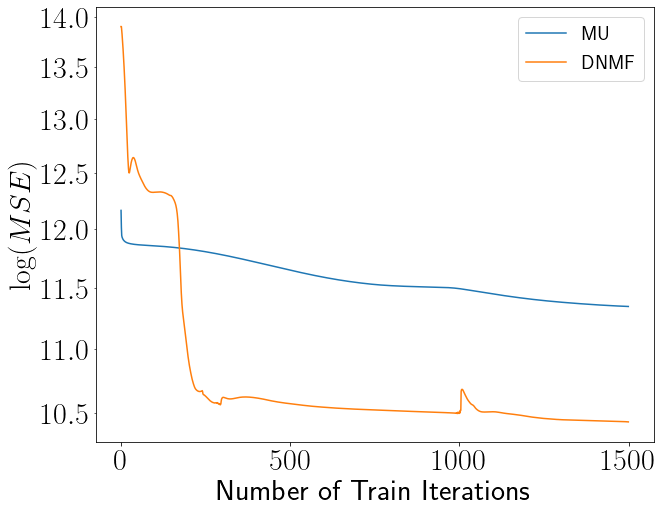

In [ ]:
  plt.rcParams['figure.figsize'] = (10, 8.0)
  epochs = range(0, mu_test_iter - 1)
  plt.semilogy(np.log(fig_7_brca['MU_L1']), label="MU")
  plt.semilogy(np.log(fig_7_brca['dnmf_L1']), label="DNMF")
  plt.xlabel("Number of Train Iterations")
  plt.ylabel("$\log(MSE)$")
  plt.legend()
  ax=plt.gca()
  ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())
  plt.savefig(f"plots/fig8/unsupervised_brca_mu_compare_train_L1.pdf")
  plt.show()

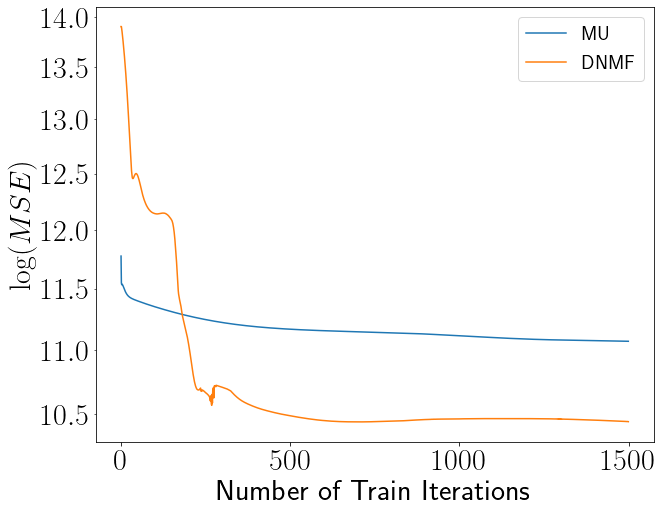

In [ ]:
  plt.rcParams['figure.figsize'] = (10, 8.0)
  epochs = range(0, mu_test_iter - 1)
  plt.semilogy(np.log(fig_7_brca['MU_L2']), label="MU")
  plt.semilogy(np.log(fig_7_brca['dnmf_L2']), label="DNMF")
  plt.xlabel("Number of Train Iterations")
  plt.ylabel("$\log(MSE)$")
  plt.legend()
  ax=plt.gca()
  ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())
  plt.savefig(f"plots/fig8/unsupervised_brca_mu_compare_train_L2.pdf")
  plt.show()